In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import hdbscan

import geopandas as gpd
import contextily as ctx
from shapely.geometry import point

import io
import os
import zipfile
import requests

import warnings
warnings.filterwarnings('ignore')

**Download map for reference**

In [2]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip'
output_dir = '/Users/nareshdhami/Desktop/Visual Code/Coursera_ML/'
# *OR simply use: './' for current directory

# Directory to save the extracted TIFF file './' is current directory
os.makedirs(output_dir, exist_ok=True)

# Step 1: Download the ZIP file
response = requests.get(url)
response.raise_for_status()

# Step 2: Open the ZIP file in memory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:

    # Step 3: Iterate over the files in the ZIP
    for file_name in zip_ref.namelist():
        if file_name.endswith('.tif'): # Check if it's a TIFF file
            # Step 4: Extract the TIFF file
            zip_ref.extract(file_name, output_dir)
            print(f'Downloaded and extracted: {file_name}')

Downloaded and extracted: Canada.tif


**Load Data**

In [3]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(url, encoding='ISO-8859-1')
df.head()

Index                      Facility_Name            Source_Facility_Type  \
0      1                   #Hashtag Gallery                              ..   
1      2  'Ksan Historical Village & Museum  historic site-building or park   
2      3               'School Days' Museum       community/regional museum   
3      4                   10 Austin Street       built heritage properties   
4      5              10 Gates Dancing Inc.                            arts   

         ODCAF_Facility_Type                      Provider Unit Street_No  \
0                    gallery                       toronto   ..       801   
1                     museum  canadian museums association   ..      1500   
2                     museum  canadian museums association   ..       427   
3  heritage or historic site                       moncton   ..        10   
4              miscellaneous                        ottawa   ..        ..   

   Street_Name Postal_Code         City Prov_Terr  \
0  dundas st w     M6J 1V2      toronto        on   
1       62 hwy     V0J 1Y0     hazelton        bc   
2     queen st     E3B 5R6  fredericton        nb   
3    austin st     E1C 1Z6      moncton        nb   
4           ..          ..       ottawa        on   

                               Source_Format_Address     CSD_Name   CSDUID  \
0                                    801 dundas st w      Toronto  3520005   
1  1500 hwy 62 hazelton british columbia v0j 1y0 ...     Hazelton  5949022   
2  427 queen st fredericton new brunswick e3b 5r6...  Fredericton  1310032   
3                                       10 austin st      Moncton  1307022   
4                                                 ..       Ottawa  3506008   

  PRUID     Latitude     Longitude  
0    35  43.65169472  -79.40803272  
1    59   55.2645508  -127.6428124  
2    13    45.963283   -66.6419017  
3    13  46.09247776  -64.78022946  
4    35  45.40856224  -75.71536766

**Plotting Function**

In [4]:
def plot_clustered_locations(df, title='Museums Clustered by Proximity'):
    """
    Plots clustered locations and overlays on a basemap.
    
    Parameters:
    - df: DataFrame containing 'Latitude', 'Longitude', and 'Cluster' columns
    - title: str, title of the plot
    """

    # Load the coordinates intto a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326")

    # Reproject to Web Mercator to align with basemap
    gdf = gdf.to_crs(epsg=3857)

    # Create subplot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Separate non-noise, or clustered points from noise, or unclustered points
    non_noise = gdf[gdf['Cluster']!=-1]
    noise = gdf[gdf['Cluster']==-1]

    # Plot noise points 
    noise.plot(ax=ax, color='k', ec='r', label='Noise', alpha=0.6)

    # Plot non-noise points
    non_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, ec='k', legend=False, alpha=0.5)

    # Add basemap of  Canada
    ctx.add_basemap(ax, source='./Canada.tif', zoom=4)

    # Format plot
    plt.title(title, )
    plt.xlabel('Longitude', )
    plt.ylabel('Latitude', )
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    
    # Show the plot
    plt.show()

**EDA**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7972 entries, 0 to 7971
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Index                  7972 non-null   int64 
 1   Facility_Name          7972 non-null   object
 2   Source_Facility_Type   7972 non-null   object
 3   ODCAF_Facility_Type    7972 non-null   object
 4   Provider               7972 non-null   object
 5   Unit                   7972 non-null   object
 6   Street_No              7972 non-null   object
 7   Street_Name            7972 non-null   object
 8   Postal_Code            7972 non-null   object
 9   City                   7972 non-null   object
 10  Prov_Terr              7972 non-null   object
 11  Source_Format_Address  7972 non-null   object
 12  CSD_Name               7972 non-null   object
 13  CSDUID                 7972 non-null   object
 14  PRUID                  7972 non-null   object
 15  Latitude             

**Checking Facility Column**

In [6]:
df['ODCAF_Facility_Type'].unique()

array(['gallery', 'museum', 'heritage or historic site', 'miscellaneous',
       'library or archives', 'artist',
       'theatre/performance and concert hall', 'art or cultural centre',
       'festival site'], dtype=object)

In [7]:
df['ODCAF_Facility_Type'].value_counts()

ODCAF_Facility_Type
library or archives                     3013
museum                                  1938
gallery                                  810
heritage or historic site                620
theatre/performance and concert hall     583
festival site                            346
miscellaneous                            343
art or cultural centre                   225
artist                                    94
Name: count, dtype: int64

**Separating `museum` only**

In [8]:
museums = df[df['ODCAF_Facility_Type']=='museum']
museums.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
museum    1938
Name: count, dtype: int64

**Filtering only `Latitude` and `Longitude`**

In [9]:
df = df[['Latitude', 'Longitude']]
type(df['Latitude'][0])

str

As Data are in string format, we have to convert data to float

**Method: 1**

In [10]:
lat_float = pd.to_numeric(df['Latitude'], errors='coerce')
long_float = pd.to_numeric(df['Longitude'], errors='coerce')
(lat_float, long_float)

(0       43.651695
 1       55.264551
 2       45.963283
 3       46.092478
 4       45.408562
           ...    
 7967    43.421356
 7968    48.422420
 7969    48.426005
 7970    48.431548
 7971    48.422880
 Name: Latitude, Length: 7972, dtype: float64,
 0       -79.408033
 1      -127.642812
 2       -66.641902
 3       -64.780229
 4       -75.715368
            ...    
 7967    -81.624695
 7968   -123.343553
 7969   -123.369188
 7970   -123.359069
 7971   -123.370087
 Name: Longitude, Length: 7972, dtype: float64)

**Method: 2**

In [11]:
df = df[df['Latitude']!='..']
df=df.drop(3859, axis=0)
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].astype(float)

In this case we know how to scale the coordinates. Using standardization would be an error becaues we aren't using the full range of the lat/lng coordinates.<br>
Since latitude has a range of +/- 90 degrees and longitude ranges from 0 to 360 degrees, the correct scaling is to double the longitude coordinates (or half the Latitudes)


In [12]:
df.Latitude[0].dtype

dtype('float64')

In [13]:
coord_scaled = df.copy()
coord_scaled['Latitude'] = 2*coord_scaled['Latitude']

**Apply `DBSCAN` with Euclidean distance to the scaled coordinates**

In [14]:
eps = 1.0 # neighbourhood search radius
min_sample = 3 # minimum number of samples needed to form a neighbourhood
metric = 'euclidean' #Distance measure

In [15]:
dbscan = DBSCAN(eps=eps, min_samples=min_sample, metric=metric)
dbscan.fit(coord_scaled)

DBSCAN(eps=1.0, min_samples=3)

**Add cluster labels to the DataFrame**

In [16]:
df['Cluster'] = dbscan.fit_predict(coord_scaled)
df['Cluster'].value_counts()

Cluster
 0     4643
 2      829
 10     515
 3      269
 7      171
-1       84
 14      25
 26      21
 6       20
 11      14
 17      12
 24      10
 22      10
 4        8
 31       7
 35       7
 12       7
 15       6
 34       6
 27       5
 32       5
 18       5
 1        5
 20       4
 33       4
 19       4
 38       4
 25       4
 16       4
 21       4
 9        4
 8        4
 37       3
 36       3
 5        3
 29       3
 30       3
 28       3
 13       3
 23       3
 39       3
Name: count, dtype: int64

**Plot the museums on a basemap of Canada, colored by cluster label.**

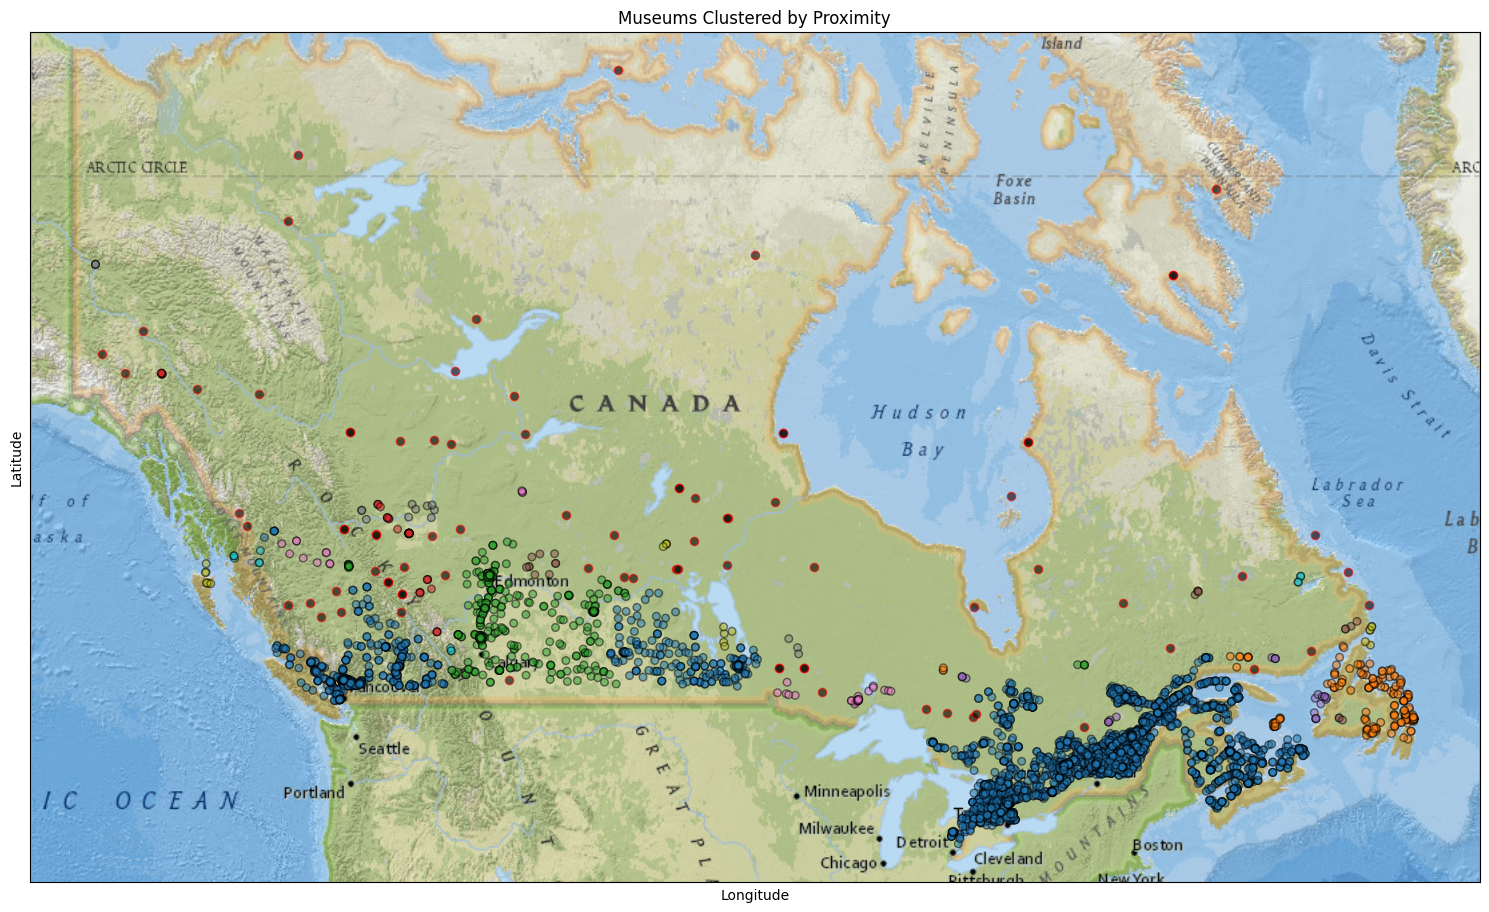

In [17]:
plot_clustered_locations(df, title='Museums Clustered by Proximity')

One key thing to notice here is that the clusters are not uniformly dense. 

For example, the points are quite densely packed in a few regions but are relatively sparse in between. 

DBSCAN agglomerates neighboring clusters together when they are close enough. 

Let's see how a hierarchical density-based clustering algorithm like HDBSCAN performs.

## Try with HDBSCAN

In [124]:
min_samples = None
min_cluster_size = 3
hdb = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric=metric)

**Adding Cluster Labels to the dataframe**

In [125]:
df_hdb = df.copy()
df_hdb['Cluster'] = hdb.fit_predict(coord_scaled)
df_hdb['Cluster'].value_counts()

Cluster
-1      2038
 348      81
 326      38
 81       38
 259      33
        ... 
 405       3
 287       3
 127       3
 510       3
 557       3
Name: count, Length: 630, dtype: int64

**Plotting data**

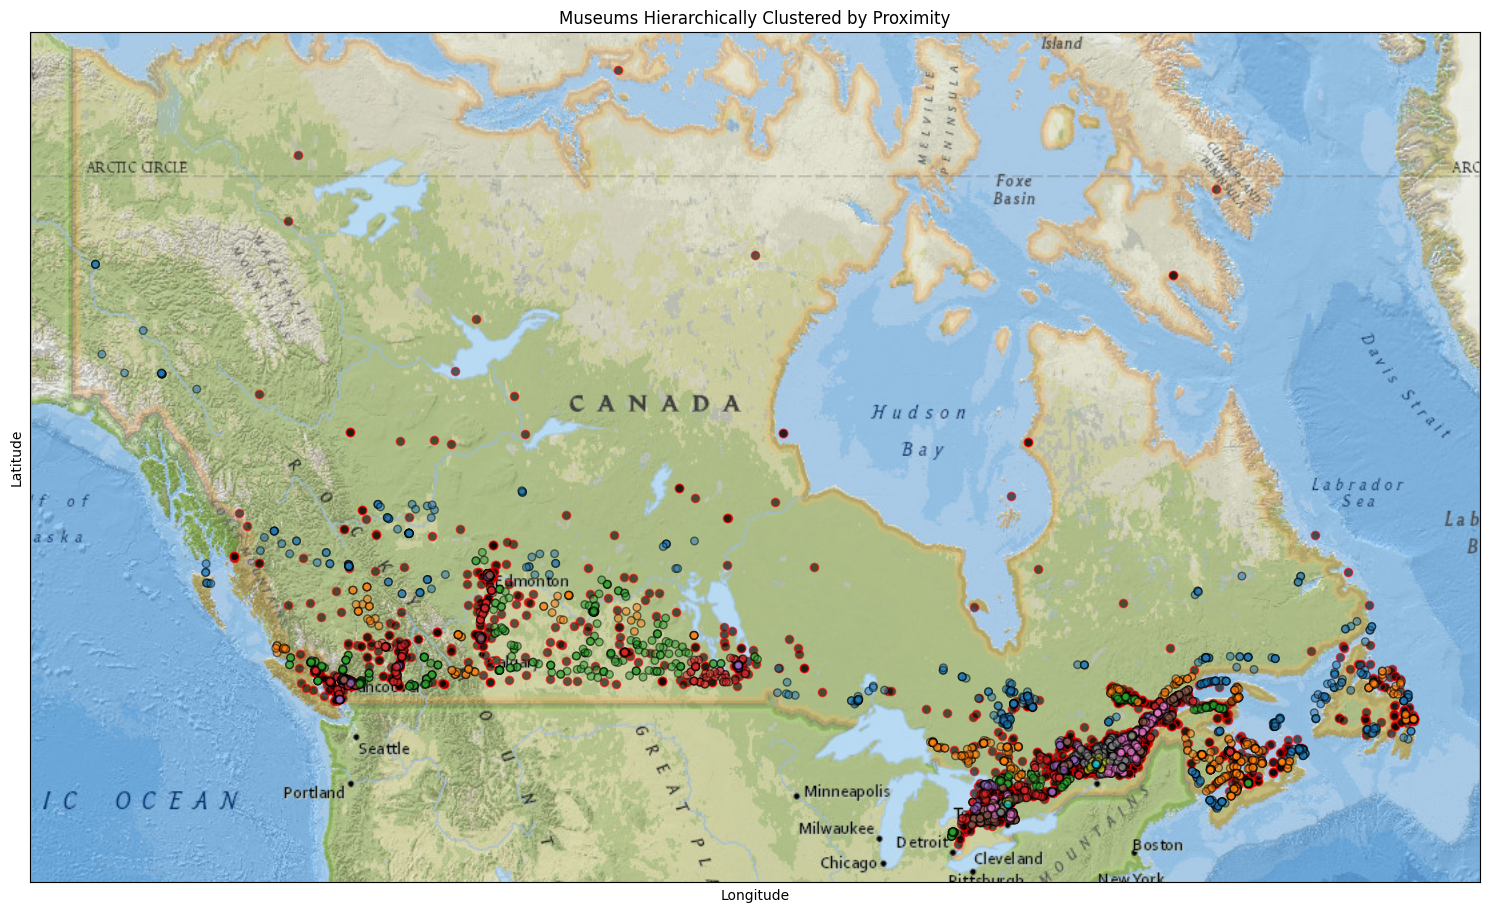

In [126]:
plot_clustered_locations(df_hdb, title='Museums Hierarchically Clustered by Proximity')